In [4]:
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable


In [5]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam
import os

In [6]:
# Configuration
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 2

In [7]:
# Dataset paths
train_path = os.path.join('Dataset\Train')
valid_path = os.path.join('Dataset\Validation')
test_path = os.path.join('Dataset\Test')

<>:2: SyntaxWarning: invalid escape sequence '\T'
<>:3: SyntaxWarning: invalid escape sequence '\V'
<>:4: SyntaxWarning: invalid escape sequence '\T'
<>:2: SyntaxWarning: invalid escape sequence '\T'
<>:3: SyntaxWarning: invalid escape sequence '\V'
<>:4: SyntaxWarning: invalid escape sequence '\T'
C:\Users\P MANOHAR REDDY\AppData\Local\Temp\ipykernel_13088\2805895122.py:2: SyntaxWarning: invalid escape sequence '\T'
  train_path = os.path.join('Dataset\Train')
C:\Users\P MANOHAR REDDY\AppData\Local\Temp\ipykernel_13088\2805895122.py:3: SyntaxWarning: invalid escape sequence '\V'
  valid_path = os.path.join('Dataset\Validation')
C:\Users\P MANOHAR REDDY\AppData\Local\Temp\ipykernel_13088\2805895122.py:4: SyntaxWarning: invalid escape sequence '\T'
  test_path = os.path.join('Dataset\Test')


In [8]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

validation_generator = val_test_datagen.flow_from_directory(
    valid_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


Found 140002 images belonging to 2 classes.
Found 39428 images belonging to 2 classes.
Found 10905 images belonging to 2 classes.


In [9]:
# Load MobileNetV2 base model
base_model = MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                         include_top=False,
                         weights='imagenet')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 140s 15us/step


In [10]:
# Freeze base layers except last 30
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

In [11]:
# Build model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.4),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

In [12]:
# Learning rate scheduler
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.9
)

optimizer = Adam(learning_rate=lr_schedule)


In [13]:
# Compile model
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [14]:
# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [15]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[early_stop]
)

C:\Users\P MANOHAR REDDY\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 8426s 2s/step - accuracy: 0.8921 - loss: 0.4742 - val_accuracy: 0.9050 - val_loss: 0.3356
Epoch 2/2
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 8124s 2s/step - accuracy: 0.9373 - loss: 0.1659 - val_accuracy: 0.9190 - val_loss: 0.2350


In [16]:
# Evaluate model
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

341/341 ━━━━━━━━━━━━━━━━━━━━ 376s 1s/step - accuracy: 0.8864 - loss: 0.3793
Test Accuracy: 80.34%


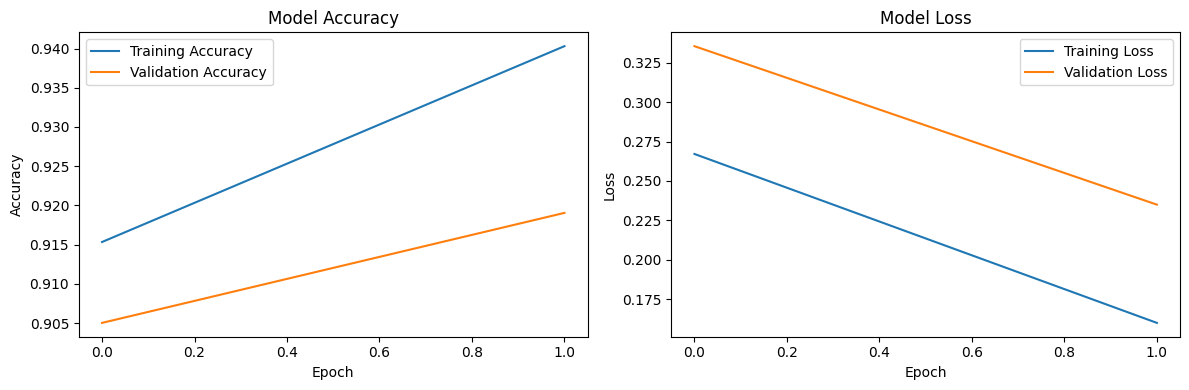

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


341/341 ━━━━━━━━━━━━━━━━━━━━ 276s 807ms/step


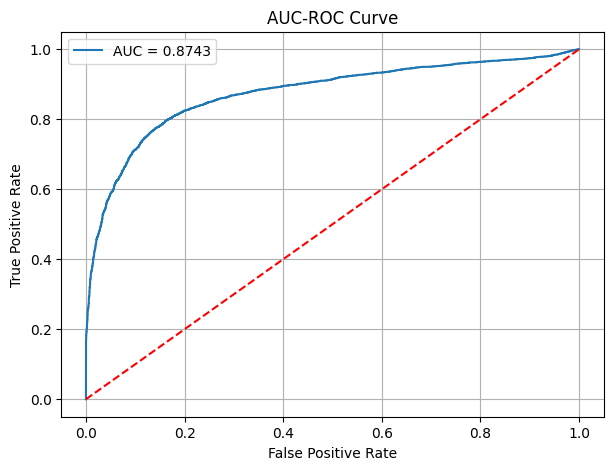

In [18]:
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np

# Reset generator and predict probabilities
test_generator.reset()
y_pred_prob = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_true = test_generator.classes

# Compute AUC-ROC
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
auc = roc_auc_score(y_true, y_pred_prob)

# Plot AUC-ROC
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve')
plt.legend()
plt.grid(True)
plt.show()


341/341 ━━━━━━━━━━━━━━━━━━━━ 273s 801ms/step


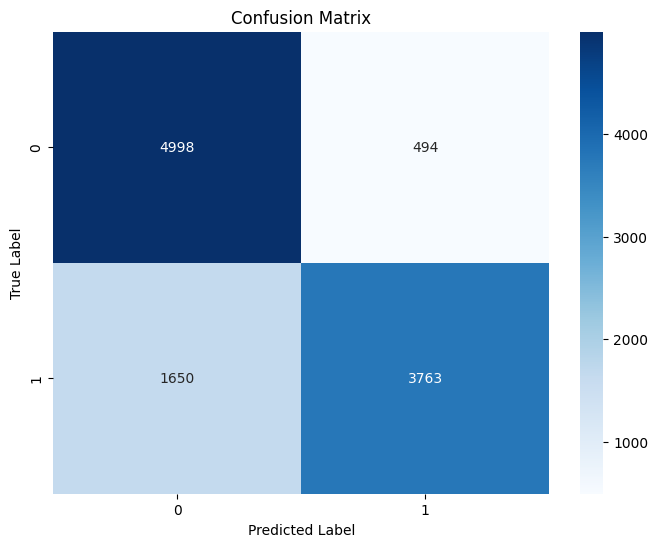

Classification Report:
              precision    recall  f1-score   support

        Real       0.75      0.91      0.82      5492
        Fake       0.88      0.70      0.78      5413

    accuracy                           0.80     10905
   macro avg       0.82      0.80      0.80     10905
weighted avg       0.82      0.80      0.80     10905



In [19]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def plot_confusion_matrix():
    # Get predicted class labels
    test_generator.reset()
    y_pred_prob = model.predict(test_generator, steps=len(test_generator), verbose=1)
    y_pred = (y_pred_prob > 0.5).astype(int)

    y_true = test_generator.classes

    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Print classification metrics
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=['Real', 'Fake']))

# Call the function
plot_confusion_matrix()


Visualizing predictions on test data:
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


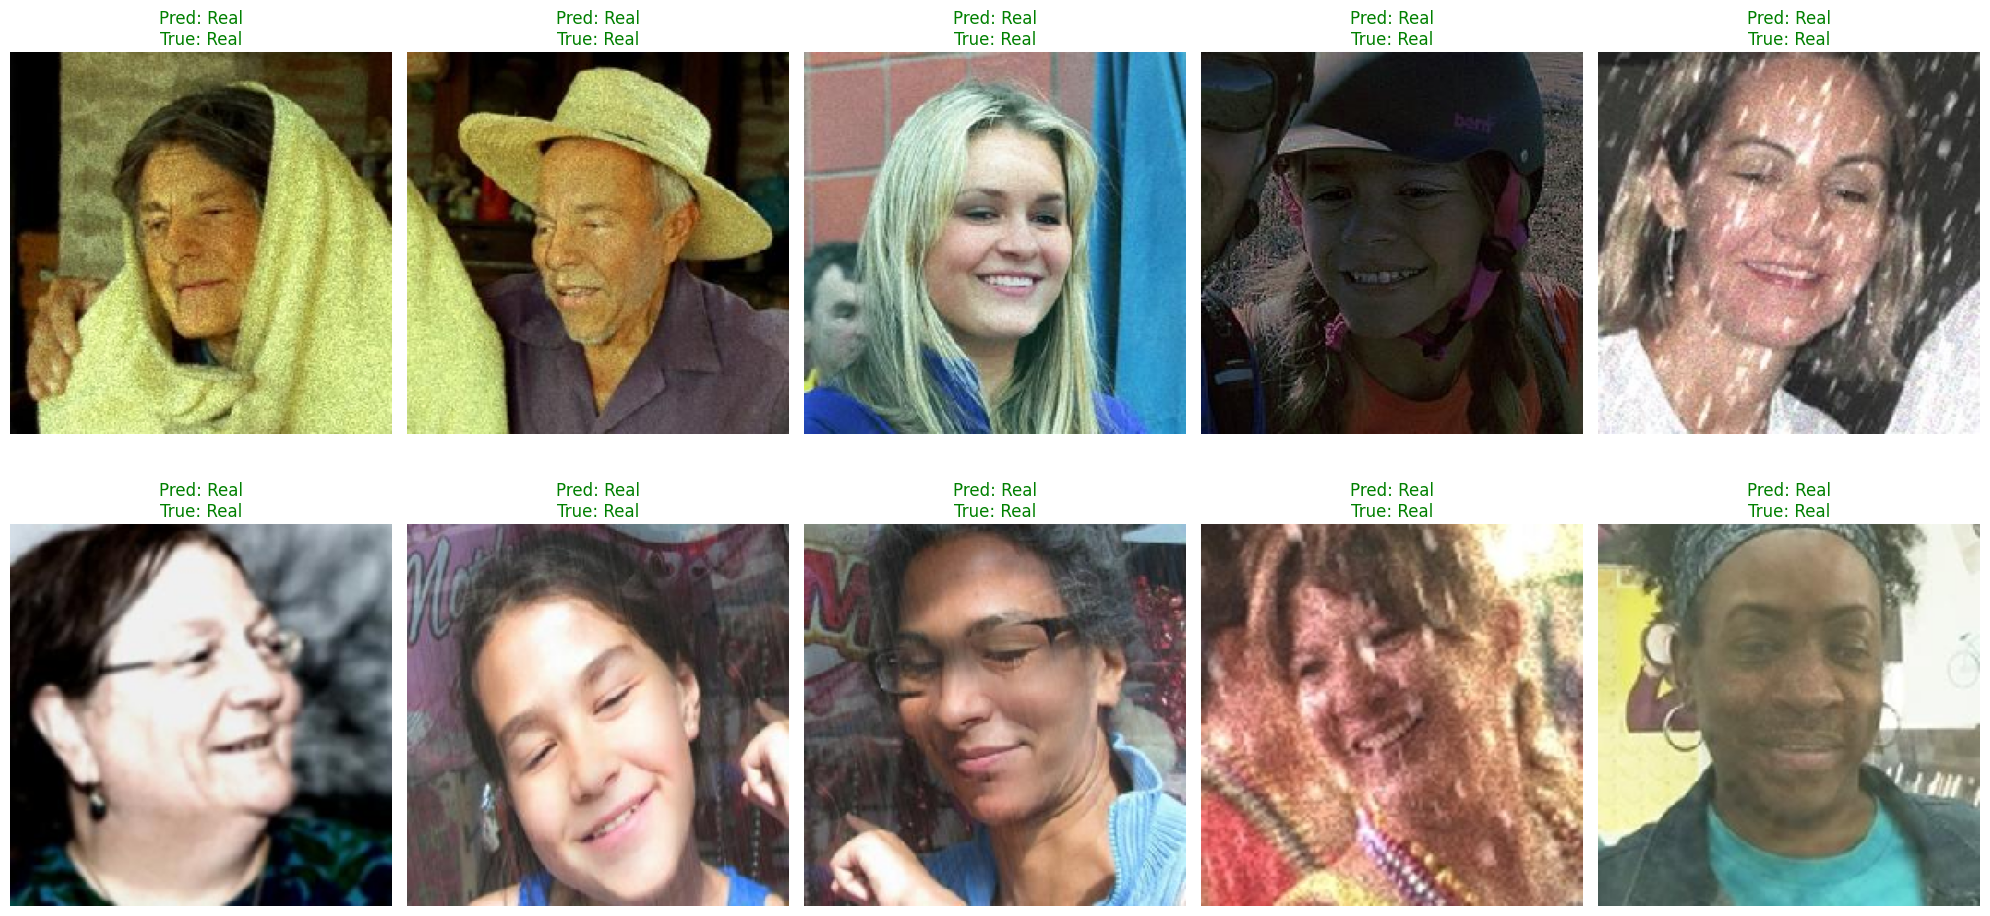

In [20]:
#Visualize Test Predictions
import random
import matplotlib.pyplot as plt

def plot_prediction_grid(generator, num_images=10):
    plt.figure(figsize=(20, 10))

    # Get a random batch from the generator
    images, true_labels = next(generator)

    # Make predictions on the batch
    predictions = model.predict(images)

    for idx in range(min(num_images, len(images))):
        plt.subplot(2, 5, idx + 1)
        plt.imshow(images[idx])
        
        pred_label = "Fake" if predictions[idx] > 0.5 else "Real"
        true_label = "Fake" if true_labels[idx] > 0.5 else "Real"

        # Color title based on prediction match
        color = 'green' if pred_label == true_label else 'red'
        plt.title(f'Pred: {pred_label}\nTrue: {true_label}', color=color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize predictions on test set
print("Visualizing predictions on test data:")
plot_prediction_grid(test_generator)

In [21]:
import json

# Evaluate model if not already done
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)

performance_metrics = {
    'test_accuracy': float(test_accuracy),
    'test_loss': float(test_loss),
    'final_train_accuracy': float(history.history['accuracy'][-1]),
    'final_train_loss': float(history.history['loss'][-1]),
    'final_val_accuracy': float(history.history['val_accuracy'][-1]),
    'final_val_loss': float(history.history['val_loss'][-1])
}

with open('model_metrics.json', 'w') as f:
    json.dump(performance_metrics, f, indent=4)

print("Performance metrics saved to model_metrics.json")

Performance metrics saved to model_metrics.json


In [24]:
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable


In [27]:
from tensorflow.keras.models import load_model
model.save('model.keras')


In [28]:
from tensorflow import keras
model = keras.models.load_model("model.keras")


C:\Users\P MANOHAR REDDY\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 73 variables whereas the saved optimizer has 1 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
